In [1]:
# initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram


IBMQ.save_account('ad3965ae3913db06521d71bba9e1208319b91a9e7ab869744cd624d63a8e898cfef58312e0819dcc2a1a2ffa59a867a4fdf5f6e225c6f2c80f28e03d3bb1a61a',overwrite=True)

#IBMQ.save_account('ebadbf7da56bb61d559a2f5fecd3d1d6e60d13ce5dd374f801829f3c92cd864b124e1ad5c1fd3faa6a14a5365f9d326947df8db138604049b06192da43d6a49b',overwrite=True)

#IBMQ.save_account('676f27667e5b533a92387a7716d67080d9648d217e96873f767e3834c2861bd4590a7ffbff31002cbce3f215642436c9a2e3a731e24b797ed5acd92765a463c2',overwrite=True)
#IBMQ.save_account('ebadbf7da56bb61d559a2f5fecd3d1d6e60d13ce5dd374f801829f3c92cd864b124e1ad5c1fd3faa6a14a5365f9d326947df8db138604049b06192da43d6a49b',overwrite=True)



IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends() 

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [2]:
from qiskit import *

In [3]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

In [4]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [5]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)


n=5
qr = QuantumRegister(n)
cr = ClassicalRegister(n)
    
circuit = QuantumCircuit(qr, cr)
barriers = True


            # Apply Hadamard gate
circuit.h(qr)    
    

            # Apply Z-gate 
circuit.z(qr)  

            # Apply barrier 


            # Apply Hadamard gate
circuit.h(qr) 

            # Measure the register
    
for i in range(n):
    circuit.measure(qr[i], cr[i])

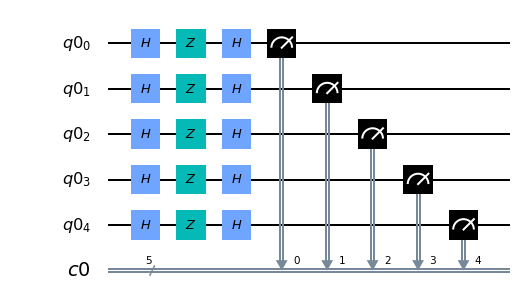

In [6]:
circuit.draw('mpl')

In [7]:
provider = IBMQ.get_provider(hub='ibm-q')
#device = provider.get_backend('ibmq_vigo')

In [8]:
FidelityFull1=[]
FidelityPartial1=[]
FidelityNoisy1=[]

JobIDFull1=[]
JobIDPartial1=[]
JobID_DJA1=[]

MatrixFull1=[]
MatrixPartial1=[]

In [9]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels = complete_meas_cal(qr=circuit.qregs[0], 
                                               circlabel='measurement_calibration')
device = provider.get_backend('ibmq_essex')
bit='11111'

for j in range (0,14):
    
    Trials=2**j  
    #Trials=8192
    
    job = execute(circuit, backend=device, shots=Trials)
    device_result = job.result()
    a=device_result.get_counts(circuit).get(bit)
    
    
    cal_job = execute(cal_circuits,
             backend=device,
             shots=Trials,
             optimization_level=0)
    #print(cal_job.job_id())

    cal_results = cal_job.result()

    index=2**n-1
    cal_job_partial = execute(cal_circuits[index],
             backend=device,
             shots=Trials,
             optimization_level=0)
    cal_results_partial = cal_job_partial.result()
    #JobIDPartial.append(cal_job_partial.job_id())
   
    meas_fitter = CompleteMeasFitter(cal_results, state_labels)
    meas_fitter_partial = CompleteMeasFitter(cal_results_partial, state_labels)
    for k in range (2**n-1):
        meas_fitter_partial.cal_matrix[k,k]=1
        
    
    meas_filter_partial =meas_fitter_partial.filter
    mitigated_result_partial = meas_filter_partial.apply(device_result)
    mitigated_counts_partial = mitigated_result_partial.get_counts(circuit)
    
    meas_filter =meas_fitter.filter
    mitigated_result = meas_filter.apply(device_result)
    mitigated_counts = mitigated_result.get_counts(circuit)
    
    FidelityNoisy1.append(device_result.get_counts(circuit).get(bit)/Trials)
    FidelityPartial1.append(mitigated_counts_partial.get(bit)/Trials)
    FidelityFull1.append(mitigated_counts.get(bit)/Trials)
    
    JobIDFull1.append("'"+str(cal_job.job_id())+"'")
    JobIDPartial1.append("'"+str(cal_job_partial.job_id())+"'")
    JobID_DJA1.append("'"+str(job.job_id())+"'")
    
    MatrixFull1.append(meas_fitter.cal_matrix)
    MatrixPartial1.append(meas_fitter_partial.cal_matrix)

In [10]:
def MatlabStr(array):
    return '[' + "; ".join(" ".join("%6g" % val for val in line) for line in array) + ']'

In [11]:
print(FidelityFull1)
print(FidelityPartial1)
print(FidelityNoisy1)

print(JobIDFull1)
print(JobIDPartial1)
print(JobID_DJA1)

print(MatrixFull1)
print(MatrixPartial1)

[1.0, 0.9999999999016027, 0.4178802789505249, 0.9117647060207372, 0.808784688299397, 0.7798116817282461, 0.8228866995790366, 0.9139683075703504, 0.9591422982166079, 0.9210143621760638, 0.9334023537500423, 0.9622270630501261, 0.9946798304362771, 1.0]
[0.02405587402623491, 0.03246316541391306, 0.8181818199135987, 0.9999999999999998, 0.8165552392561882, 0.8964674980507397, 0.8160215391520633, 0.9999999999999647, 0.9999999999999687, 0.9340958364541523, 0.9858335716897206, 0.9979343098409085, 0.9328154284939195, 0.9986544307839593]
[1.0, 0.5, 0.75, 0.75, 0.625, 0.625, 0.578125, 0.640625, 0.6796875, 0.625, 0.646484375, 0.6484375, 0.633056640625, 0.6851806640625]
["'5f2b9a9af0563e001a6cbe9a'", "'5f2b9b0dfa2efe0013961650'", "'5f2b9b859b21aa001a1cac5e'", "'5f2b9bfe0ca1ba0011b3d640'", "'5f2b9c73c79cc2001a3acaa8'", "'5f2b9d9b9b21aa001a1cac74'", "'5f2b9ee00927b800133f9ac7'", "'5f2b9fb2f0563e001a6cbecc'", "'5f2ba060f0563e001a6cbed2'", "'5f2ba1184ae7da001b374566'", "'5f2ba28fcbff540019b430b4'", "'5f

        4.88281250e-04, 1.33056641e-02, 9.76562500e-03, 6.54174805e-01]])]
[array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.

        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.83227539e-01]])]


# Here I put the full matrices

In [12]:
for j in MatrixFull1:
    print(MatlabStr(j))

[     1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      1      0      0      0      0      0      0;      0      0      1      0      0      0      0      0      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      0      1      0      0      0      0      0      0      0      0      0  

[     1    0.5    0.5      0    0.5      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0    0.5      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0    0.5      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      0    0.5      0      0      0      0      0      0      0      0      0  

[     1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0    0.5      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      1      0   0.25      0   0.25      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      1      0      0      0   0.25      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0   0.75      0      0      0      0      0      0      0   0.25      0      0      0      0      0      0      0   0.25      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      0      1      0      0      0      0      0      0      0      0      0  

[     1      0      0      0  0.125      0      0      0      0      0  0.125      0      0      0      0      0      0      0      0      0      0      0      0      0  0.125      0      0      0      0      0      0      0;      0      1      0      0      0      0      0      0      0      0      0  0.125      0      0      0      0      0   0.25      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0  0.875      0      0      0      0      0      0      0   0.25      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0  0.875      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0   0.25      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      0  0.625      0      0      0      0      0      0      0      0      0  

[     1      0 0.0625      0      0      0      0      0  0.125      0      0      0      0      0      0      0 0.1875      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      1      0      0      0      0      0      0      0      0      0 0.0625      0      0      0      0      0  0.125      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0  0.875      0      0      0      0      0      0      0  0.125      0      0      0      0      0      0      0 0.1875      0      0      0      0      0      0      0      0 0.0625      0      0      0      0;      0      0 0.0625 0.9375      0      0      0      0      0      0      0  0.125      0      0      0      0      0      0      0  0.125      0      0      0      0      0      0      0 0.0625      0      0      0      0;      0      0      0      0      1 0.0625      0      0      0      0      0      0 0.1875      0  

[0.9375 0.09375      0      0 0.09375      0      0      0 0.0625      0      0      0 0.03125      0      0      0 0.03125      0 0.03125      0      0      0      0      0      0      0      0      0      0      0      0      0;      0  0.875      0 0.03125      0      0      0      0      0 0.09375      0      0      0      0      0      0      0  0.125      0      0      0      0      0      0      0      0      0      0      0      0      0      0; 0.03125      0 0.78125 0.09375      0      0 0.09375      0      0      0 0.1875 0.03125      0      0      0      0      0      0 0.15625      0      0      0      0      0      0      0 0.03125      0      0      0      0      0;      0      0 0.09375 0.78125      0      0      0 0.09375      0      0      0      0      0      0      0      0      0      0      0  0.125      0      0      0      0      0      0      0 0.03125      0      0      0      0; 0.03125      0      0      0 0.84375      0 0.0625      0      0      0      0   

[0.90625 0.015625 0.09375      0 0.0625      0 0.015625      0 0.109375      0      0      0 0.015625      0      0      0 0.09375      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0; 0.015625 0.953125      0 0.046875      0 0.0625      0      0      0 0.15625      0 0.015625      0      0      0      0      0 0.09375      0 0.03125      0      0      0      0      0      0      0      0      0      0      0      0; 0.046875      0 0.890625 0.015625      0      0 0.0625 0.015625      0      0 0.03125      0      0      0      0      0      0      0  0.125      0      0      0      0      0      0      0      0      0      0      0      0      0;      0 0.015625      0  0.875      0      0      0 0.078125      0      0      0 0.046875      0      0      0      0      0      0      0 0.109375      0      0      0      0      0      0      0 0.015625      0      0      0      0; 0.015625      0      0      0 0.890625 0.015625 0.046875  

[0.914062 0.0546875 0.0703125      0 0.046875      0 0.0078125      0 0.0859375      0      0      0 0.0078125      0      0      0 0.132812      0 0.0234375      0      0      0 0.0078125      0 0.015625      0      0      0 0.0078125 0.0078125      0      0; 0.0078125 0.914062      0 0.0625      0 0.0625      0      0      0 0.0546875      0      0      0 0.0078125      0      0 0.0078125 0.101562      0 0.0078125      0      0      0      0      0      0      0      0      0      0      0      0; 0.0078125 0.0078125 0.867188 0.0390625      0 0.0078125 0.0625      0      0      0  0.125      0 0.015625      0      0      0      0      0 0.140625      0      0      0      0      0      0      0 0.0078125      0      0      0      0      0;      0      0      0 0.851562      0 0.0078125      0 0.0546875      0      0      0 0.046875      0      0      0      0      0      0      0 0.09375      0      0      0 0.0078125      0      0      0 0.0078125      0      0      0 0.0078125;     

[0.90625 0.03125 0.0820312      0 0.0351562      0 0.00390625      0 0.0507812 0.00390625 0.0078125      0 0.00390625      0      0      0 0.136719 0.00390625 0.0117188 0.00390625 0.0078125      0      0      0 0.0117188      0      0      0      0      0      0      0; 0.0429688 0.941406      0 0.0507812      0 0.0234375      0 0.00390625 0.00390625 0.0625      0 0.0117188      0 0.00390625      0      0 0.00390625 0.128906      0 0.015625      0 0.00390625      0 0.00390625      0 0.015625      0      0      0      0      0      0; 0.0234375      0 0.839844 0.078125      0      0 0.0390625      0      0      0 0.0546875      0 0.00390625      0 0.00390625      0      0      0 0.101562 0.00390625      0      0 0.00390625      0      0      0 0.0078125      0      0      0      0      0; 0.00390625      0 0.0273438 0.828125      0 0.00390625 0.00390625 0.0429688      0      0      0 0.0625      0      0      0 0.00390625      0 0.0078125 0.015625 0.109375      0 0.00390625      0      

[0.912109 0.0410156 0.0644531 0.00195312 0.0546875      0 0.00195312      0 0.0761719 0.00195312 0.00585938 0.00195312 0.0078125      0 0.00195312      0 0.107422 0.00195312 0.0078125      0      0      0 0.00195312      0 0.00976562      0      0      0 0.00195312      0      0      0; 0.015625 0.898438 0.00390625 0.0546875 0.00195312 0.0390625      0 0.00390625      0 0.0625      0 0.0136719      0 0.00195312      0      0      0 0.117188      0 0.00976562      0 0.00195312      0      0      0 0.0136719 0.00195312      0      0      0      0      0; 0.0117188      0 0.876953 0.0332031 0.00195312      0 0.0234375 0.00195312 0.00195312      0 0.0878906 0.00390625      0      0 0.00195312      0      0 0.00195312 0.101562 0.00585938      0      0 0.00195312      0 0.00195312      0 0.0117188 0.00195312      0      0 0.00195312      0; 0.00195312 0.00585938 0.0078125 0.859375      0      0      0 0.0566406      0      0      0 0.0664062      0      0      0      0      0      0 0.003906

[0.895508 0.0322266 0.0849609 0.000976562 0.0361328 0.00195312 0.00585938      0 0.0683594 0.00390625 0.00585938      0 0.00292969      0      0      0 0.126953 0.00488281 0.0078125      0 0.0078125 0.000976562      0      0 0.0146484      0 0.000976562      0 0.000976562      0      0      0; 0.0253906 0.890625      0 0.0771484      0 0.0498047 0.000976562 0.00390625 0.000976562 0.0742188      0 0.00683594      0 0.000976562      0      0 0.00390625 0.12793      0 0.0126953      0 0.00683594      0 0.00195312 0.000976562 0.0126953      0      0      0      0      0      0; 0.0166016      0 0.834961 0.0458984 0.00390625      0 0.0361328 0.00292969 0.00488281      0 0.0732422 0.00195312      0      0 0.00585938      0      0      0 0.114258 0.00390625      0      0 0.00390625      0      0      0 0.00976562 0.000976562      0      0      0      0; 0.000976562 0.0175781 0.015625 0.806641      0 0.00390625 0.000976562 0.0380859 0.000976562 0.00390625 0.00195312 0.0693359      0 0.00097656

[0.908203 0.0532227 0.0615234 0.00292969 0.0507812 0.000488281 0.00244141 0.000488281 0.0688477 0.00341797 0.00830078      0 0.000976562      0      0      0 0.115723 0.00732422 0.00683594      0 0.00683594 0.000488281      0      0 0.0141602 0.00146484 0.000976562      0 0.000488281      0      0      0; 0.0297852 0.883789 0.00390625 0.0664062 0.00195312 0.0419922 0.000488281 0.00488281 0.00244141 0.0620117      0 0.00585938 0.000976562 0.00341797      0      0 0.00537109 0.0981445 0.000488281 0.00537109      0 0.00292969      0 0.00146484 0.000488281 0.0146484      0 0.000976562      0      0      0      0; 0.0283203 0.000976562 0.815918 0.0488281 0.00195312      0 0.0375977 0.00292969 0.00244141      0 0.0629883 0.00390625 0.000976562      0 0.00292969      0 0.00195312      0 0.102539 0.00537109 0.000488281 0.000488281 0.00585938 0.000488281 0.000488281      0 0.0107422 0.000976562 0.000488281      0 0.000976562      0; 0.000488281 0.0214844 0.0244141 0.797852      0 0.00292969 0.0

[0.65332 0.0598145 0.0917969 0.00952148 0.0239258 0.00219727 0.00561523 0.000732422 0.0595703 0.00756836 0.015625 0.00219727 0.00268555 0.000488281 0.000976562 0.000244141 0.109863 0.0119629 0.0178223 0.000976562 0.00415039 0.000976562 0.0012207 0.000488281 0.0129395 0.0012207 0.00390625 0.000488281 0.000732422      0      0      0; 0.0686035 0.654541 0.0124512 0.0993652 0.00390625 0.0288086 0.000488281 0.00390625 0.00756836 0.0710449 0.00268555 0.0163574 0.000244141 0.00415039 0.000488281 0.000732422 0.0102539 0.123047 0.00390625 0.0153809 0.000732422 0.00512695      0 0.000732422 0.000488281 0.0100098 0.000244141 0.00390625      0 0.000488281      0      0; 0.115967 0.00952148 0.672119 0.0527344 0.00634766 0.000488281 0.0327148 0.00195312 0.0205078 0.000976562 0.0690918 0.00463867 0.00268555      0 0.00317383      0 0.0175781 0.00292969 0.117188 0.00805664 0.000732422      0 0.00537109 0.0012207 0.00415039 0.000732422 0.00878906 0.00317383 0.000732422      0 0.000488281 0.000244141; 

[0.861694 0.0375977 0.0601807 0.00305176 0.0393066 0.00195312 0.00354004 0.000366211 0.0665283 0.00280762 0.00476074 0.00012207 0.00378418      0 0.000610352      0 0.140869 0.00683594 0.00927734 0.000488281 0.00793457 0.000244141 0.000366211      0 0.0169678 0.000610352 0.00109863 0.000244141 0.000488281      0 0.00012207      0; 0.0134277 0.848999 0.000976562 0.0601807 0.000732422 0.039917      0 0.00244141 0.000610352 0.0675049      0 0.00476074 0.00012207 0.00341797      0 0.000610352 0.0020752 0.138672 0.00012207 0.0100098 0.00012207 0.00610352      0 0.000366211      0 0.0150146      0 0.000854492      0 0.000732422      0 0.00012207; 0.0202637 0.000854492 0.826172 0.0344238 0.00195312      0 0.0371094 0.00146484 0.00292969 0.000244141 0.0610352 0.00219727 0.000366211      0 0.00170898 0.00012207 0.00280762 0.00012207 0.13855 0.00585938 0.000610352 0.00012207 0.0057373      0 0.000366211 0.00012207 0.0140381 0.00158691 0.00012207      0 0.000244141      0; 0.000488281 0.0168457 0

# Here the partial

In [13]:
for j in MatrixPartial1:
    print(MatlabStr(j))

[     1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      0      1      0      0      0      0      0      0      0      0      0  

[     1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      0      1      0      0      0      0      0      0      0      0      0  

[     1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      0      1      0      0      0      0      0      0      0      0      0  

[     1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      0      1      0      0      0      0      0      0      0      0      0  

[     1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      0      1      0      0      0      0      0      0      0      0      0  

[     1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      0      1      0      0      0      0      0      0      0      0      0  

[     1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      0      1      0      0      0      0      0      0      0      0      0  

[     1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      0      1      0      0      0      0      0      0      0      0      0  

[     1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      0      1      0      0      0      0      0      0      0      0      0  

[     1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0 0.00195312;      0      0      0      0      1      0      0      0      0      0      0      0      0     

[     1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0 0.00195312;      0      0      0      0      1      0      0      0      0      0      0      0      0     

[     1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0 0.000976562;      0      0      0      0      1      0      0      0      0      0      0      0      0    

[     1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      0      1      0      0      0      0      0      0      0      0      0  

[     1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0;      0      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0 0.000366211;      0      0      0      0      1      0      0      0      0      0      0      0      0    